1. Plot Total Number of Transactions per Customer
First, we'll load the data, merge the datasets, and then plot the total number of transactions per customer in descending order.

   Unnamed: 0  customer_id  product_id                      date
0           0      6689489  0A4G5LZWCP  2017-01-31T09:31:08.873Z
1           1      6689489  XZ6UVEYK40  2017-02-03T16:59:16.610Z
2           2      6689489  XZ6UVEYK40  2017-02-05T19:47:55.353Z
3           3      6689489  XZ6UVEYK40  2017-02-05T19:48:14.633Z
4           4      6689489  XZ6UVEYK40  2017-02-06T09:59:49.053Z


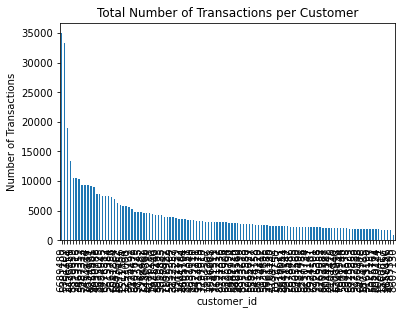

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
transactions_1 = pd.read_csv('transactions_1.csv')
transactions_2 = pd.read_csv('transactions_2.csv')

# Merge the datasets
transactions = pd.concat([transactions_1, transactions_2])
print(transactions.head())
# Count transactions per customer
transactions_per_customer = transactions['customer_id'].value_counts()

# Plot;
transactions_per_customer.sort_values(ascending=False).plot(kind='bar')
plt.xlabel('customer_id')
plt.ylabel('Number of Transactions')
plt.title('Total Number of Transactions per Customer')
plt.show()#%%


In [2]:
pd.to_datetime(transactions['date'], utc=True).describe()

<ipython-input-2-13e388e8ee2a>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pd.to_datetime(transactions['date'], utc=True).describe()


count                               512687
unique                              480663
top       2017-10-31 09:08:41.953000+00:00
freq                                     4
first     2017-01-01 18:31:30.347000+00:00
last      2020-03-17 00:08:21.430000+00:00
Name: date, dtype: object

In [3]:
column_types = transactions.dtypes
print(column_types)

Unnamed: 0      int64
customer_id     int64
product_id     object
date           object
dtype: object


2. Plot Transaction Frequency per Month for a Given Product in 2018
We'll filter the transactions for the given product and the year 2018, then plot the transaction frequency per month.

<ipython-input-4-e616d292877c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_transactions['Month'] = pd.to_datetime(product_transactions['date']).dt.month


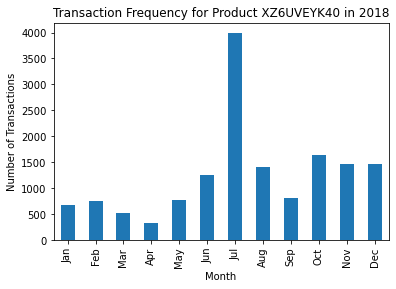

In [4]:
def plot_product_transactions(product_id):
    # Assuming `transactions['date']` is the column with timezone-aware datetime objects
    # Convert 'date' column to UTC and then remove timezone information to make it naive
    transactions['date'] = pd.to_datetime(transactions['date'], utc=True)

    # Filter for the given product and year 2018
    product_transactions = transactions[(transactions['product_id'] == product_id) &
                                        (pd.to_datetime(transactions['date']).dt.year == 2018)]
    
    # Extract month and count transactions per month
    product_transactions['Month'] = pd.to_datetime(product_transactions['date']).dt.month
    transactions_per_month = product_transactions.groupby('Month').size()
    
    # Plot
    transactions_per_month.plot(kind='bar')
    plt.xlabel('Month')
    plt.ylabel('Number of Transactions')
    plt.title(f'Transaction Frequency for Product {product_id} in 2018')
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.show()

# Example usage
plot_product_transactions('XZ6UVEYK40')

3. Predict Total Number of Transactions for the Next Three Months per Customer
For this task, we'll use a simple regression model. Given the complexity and potential variability in the data, more sophisticated models like time series forecasting (ARIMA, Prophet) or machine learning models (Random Forest, Gradient Boosting) could be considered for better accuracy.
Preprocessing
Aggregate transactions up to the end of January 2019 by customer.
Create features based on historical transaction data.
Split the data into training and testing sets.
Model Training
Train a regression model on the training set.
Predict the total number of transactions for the next three months on the test set.
Evaluation
Evaluate the model using metrics like RMSE (Root Mean Squared Error).

10:33:53 - cmdstanpy - INFO - Chain [1] start processing
10:33:54 - cmdstanpy - INFO - Chain [1] done processing


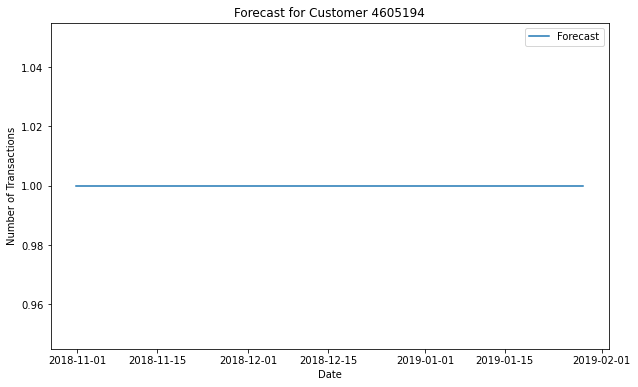

In [6]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

from pandas import Timestamp



# Assuming `transactions` DataFrame has been preprocessed to include a 'Date' column and aggregated by customer

# Sort transactions by date
transactions.sort_values(by='date', inplace=True)

# Define a split date, for example, to leave the last three months for testing
split_date = pd.to_datetime('2018-10-31')
# Convert 'ds' column to naive datetime objects by removing timezone information




# Placeholder for storing Prophet model predictions
predictions = {}

# Loop through each customer
for customer_id in transactions['customer_id'].unique():
    customer_transactions = transactions[transactions['customer_id'] == customer_id]
    customer_transactions = customer_transactions.groupby('date')['product_id'].nunique().reset_index()
    customer_transactions.columns = ['ds', 'y']
    customer_transactions['ds'] = customer_transactions['ds'].dt.tz_localize(None)
    
    # Split the data based on the date
    train = customer_transactions[customer_transactions['ds'] <= split_date]
    test = customer_transactions[customer_transactions['ds'] > split_date],
    
    
    # Instantiate and fit the Prophet model
    model = Prophet()
    model.fit(train)
    
    # Make future dataframe for 3 months
    future = model.make_future_dataframe(periods=90)
    
    # Forecast
    forecast = model.predict(future)
    
    # Store predictions
    predictions[customer_id] = forecast[['ds', 'yhat']].tail(90)

# Example: Plot the forecast for a specific customer
customer_id_example = list(predictions.keys())[0]
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(predictions[customer_id_example]['ds']), predictions[customer_id_example]['yhat'], label='Forecast')
plt.title(f'Forecast for Customer {customer_id_example}')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()
plt.show()

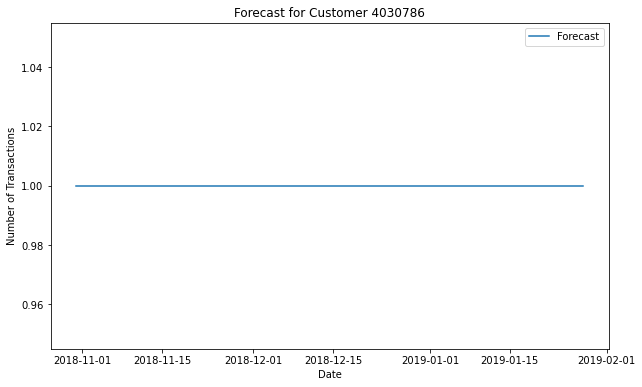

In [7]:
# Example: Plot the forecast for a specific customer
customer_id_example = list(predictions.keys())[15]
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(predictions[customer_id_example]['ds']), predictions[customer_id_example]['yhat'], label='Forecast')
plt.title(f'Forecast for Customer {customer_id_example}')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()
plt.show()

4. Identify Top 5 Products with the Highest Sales Over the Last Six Months
This requires aggregating sales data over the last six months, sorting products by sales, and identifying any seasonality effects.

<ipython-input-10-8b655b6b3979>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_transactions['date'] = pd.to_datetime(filtered_transactions['date'])


Top 5 Products with the Highest Sales Over the Last Six Months:
product_id
5RPSDK28JR    5944
XZ6UVEYK40    4660
VD51ZQPY9D    4561
XD4I34ED7F    4072
G5HEPH9A2T    3715
dtype: int64


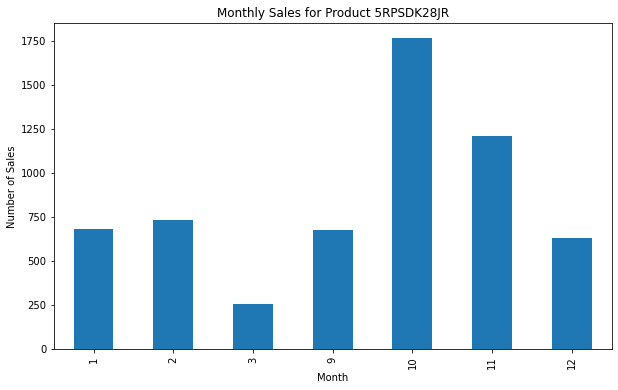

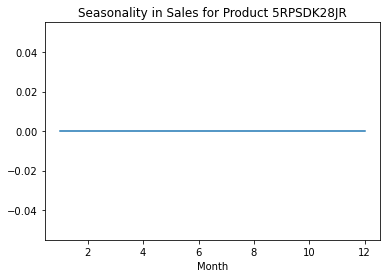

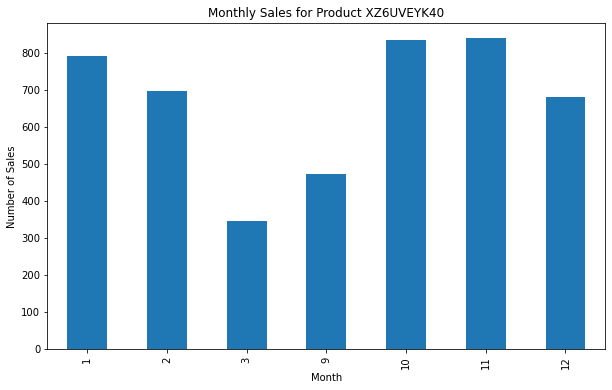

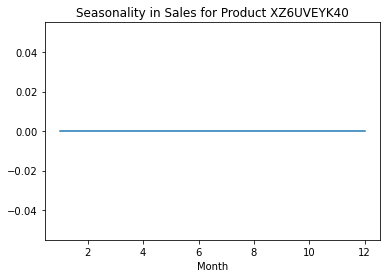

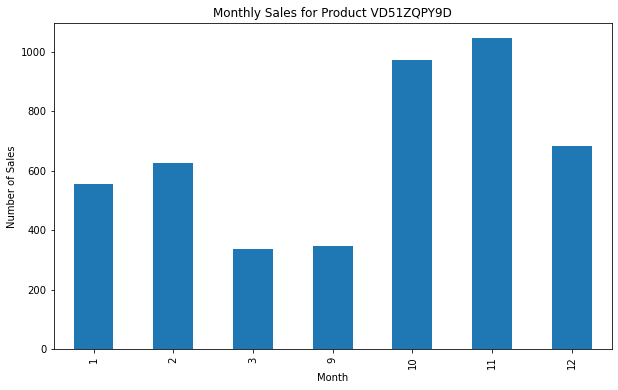

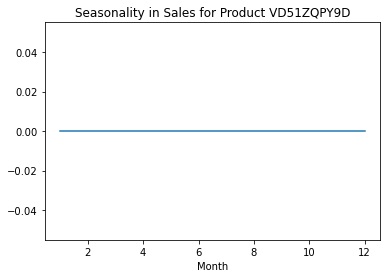

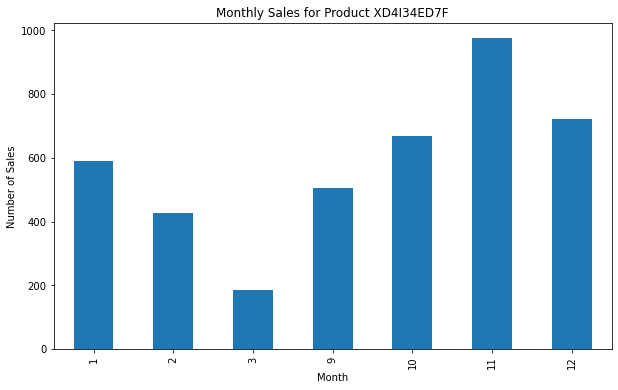

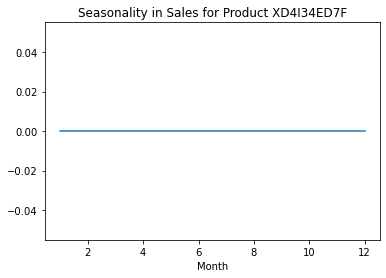

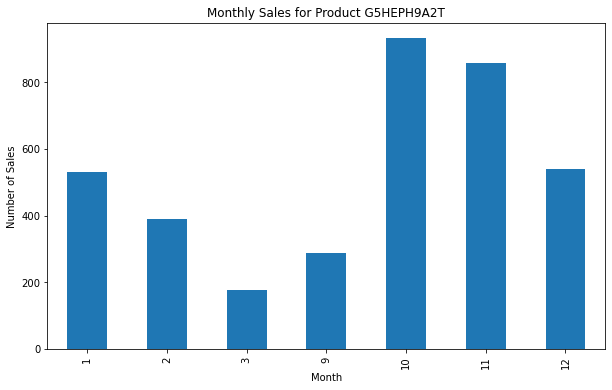

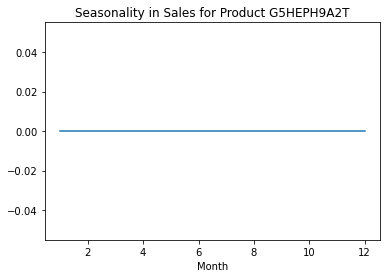

In [10]:
# Step 1: Filter transactions for the last six months
end_date = pd.to_datetime('2020-03-17')
start_date = end_date - pd.DateOffset(months=6)

transactions['date'] = transactions['date'].dt.tz_localize(None)
filtered_transactions = transactions[(pd.to_datetime(transactions['date']) >= start_date) & 
                                     (pd.to_datetime(transactions['date']) <= end_date)]
filtered_transactions['date'] = pd.to_datetime(filtered_transactions['date'])
filtered_transactions = filtered_transactions[(filtered_transactions['date'] >= start_date) & (filtered_transactions['date'] <= end_date)]

# Step 2: Count transactions (sales) by product
sales_per_product = filtered_transactions.groupby('product_id').size()

# Step 3: Identify Top 5 Products by sorting based on the transaction count
top_5_products = sales_per_product.sort_values(ascending=False).head(5)
print("Top 5 Products with the Highest Sales Over the Last Six Months:")
print(top_5_products)

# Step 4: Analyze Seasonality
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# Ensure 'Month' column exists and is derived correctly from 'date'
filtered_transactions['Month'] = filtered_transactions['date'].dt.month

for product in top_5_products.index:
    # Filter transactions for each of the top 5 products
    product_transactions = filtered_transactions[filtered_transactions['product_id'] == product]

    # Aggregate sales by month
    monthly_sales = product_transactions.groupby('Month').size()

    # Plot monthly sales
    plt.figure(figsize=(10, 6))
    monthly_sales.plot(kind='bar')
    plt.title(f'Monthly Sales for Product {product}')
    plt.xlabel('Month')
    plt.ylabel('Number of Sales')
    plt.show()

    # Decompose to analyze seasonality
    # Ensure there's enough data for decomposition
    if len(monthly_sales) > 2:
        result = seasonal_decompose(monthly_sales, model='additive', period=1)
        result.seasonal.plot(title=f'Seasonality in Sales for Product {product}')
        plt.show()
    else:
        print(f"Not enough data to analyze seasonality for Product {product}")